# Imports

In [1]:
!pip install pycaret


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn import set_config
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from pycaret.classification import setup, compare_models
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
sns.set_style('darkgrid')
set_config(transform_output='pandas')

In [3]:
def explore_cat(inspection_df, x , fillna=True , placeholder='Missing' , figsize=(7,5) , order=None) :
 temp_df = inspection_df.copy()
 null_count = temp_df[x].isna().sum()
 null_per = null_count * 100 / len(temp_df)
 if fillna == True :
  temp_df[x].fillna(placeholder , inplace = True)
 fig,ax = plt.subplots(figsize=figsize)
 sns.countplot(data=temp_df , x=x , ax=ax , order=order)
 ax.set_xticklabels(ax.get_xticklabels(), fontsize = 12 , rotation = 45 , ha = 'right')
 ax.set_title(f'column : {x}' , fontweight = 'bold' , fontsize = 15)
 sns.despine()
 fig.tight_layout()
 plt.show()
 print(f'There is {null_count} NaN ({round(null_per,2)}%)')
 nunique = temp_df[x].nunique()
 print(f'There is {nunique} unique values')
 most_common_value = temp_df[x].value_counts(dropna=False).index[0]
 freq = temp_df[x].value_counts(dropna=False).values[0]
 per_common_value = freq * 100 / len(temp_df)
 print(f'The most common value is {most_common_value} , occurs {freq} times ({round(per_common_value,2)}%)')
 if per_common_value > 98 :
  print(f'{x}: is a constant or quasi-constant feature and should be dropped')
 else :
  print(f'{x}: is neither constant or a quasi-constant feauture and should be kept')
 return fig,ax


In [4]:

def plot_cat_vs_target(inspection_df , x , y='rating' , placeholder='Missing' , order=None , figsize=(7,5) , fillna = True):
 temp_df = inspection_df.copy()
 if fillna == True:
  temp_df[x].fillna(placeholder, inplace=True)
 else:
  temp_df = temp_df.dropna(subset=[x])
 fig,ax = plt.subplots(figsize=figsize)
 sns.barplot(data=temp_df, x=x, y=y, ax=ax, order=order, alpha=0.6, linewidth=1, edgecolor='black', errorbar=None)
 sns.stripplot(data=temp_df, x=x , y=y , hue=x , ax=ax , order=order, hue_order=order, legend=False , edgecolor='white', linewidth=0.5,
 size=3,zorder=0)
 ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right' , fontsize = 12)
 ax.set_title(f"{x} vs. {y}", fontweight='bold' , fontsize=15)
 fig.tight_layout()
 plt.show()
 return fig, ax

In [5]:
def explore_num(inspection_df, x, figsize=(7.5, 5)):
    temp_df = inspection_df.copy()
    null_count = temp_df[x].isna().sum()
    null_per = null_count * 100 / len(temp_df)
    nunique = temp_df[x].nunique()
    most_common_value = temp_df[x].value_counts(dropna=False).index[0]
    freq = temp_df[x].value_counts(dropna=False).values[0]
    per_common_value = freq * 100 / len(temp_df)

    gridspec = {'height_ratios': [0.7, 0.3]}
    fig, ax = plt.subplots(nrows=2, figsize=figsize, sharex=True, gridspec_kw=gridspec)

    sns.histplot(data=temp_df, x=x, ax=ax[0])
    sns.boxplot(data=temp_df, x=x, ax=ax[1])

    ax[0].set_title(f"Column: {x}", fontweight='bold', fontsize=15)
    sns.despine()
    fig.tight_layout()
    plt.show()

    print(f'There are {null_count} NaN ({round(null_per, 2)}%)')
    print(f'There are {nunique} unique values')
    print(f'The most common value is {most_common_value}, occurs {freq} times ({round(per_common_value, 2)}%)')

    if per_common_value > 98:
        print(f'{x}: is a constant or quasi-constant feature and should be dropped')
    else:
        print(f'{x}: is neither constant nor a quasi-constant feature and should be kept')

    return fig, ax

In [6]:
def plot_num_vs_target(inspection_df ,x,y='rating' , figsize=(7,5)):
  temp_df = inspection_df.copy()
  corr = temp_df[[x,y]].corr().round(2)
  r = corr.loc[x,y]
  fig, ax = plt.subplots(figsize=figsize)
  scatter_kws={'ec':'white','lw':1,'alpha':0.7}
  sns.regplot(data=temp_df, x=x, y=y, ax=ax, scatter_kws=scatter_kws)
  ax.set_title(f"{x} vs. {y} (r = {r})", fontweight='bold')
  fig.tight_layout()
  plt.show()
  return fig, ax

# Preprocessing 

In [7]:
file_path = 'cirrhosis.csv'
df = pd.read_csv(file_path)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             418 non-null    int64  
 1   N_Days         418 non-null    int64  
 2   Status         418 non-null    object 
 3   Drug           312 non-null    object 
 4   Age            418 non-null    int64  
 5   Sex            418 non-null    object 
 6   Ascites        312 non-null    object 
 7   Hepatomegaly   312 non-null    object 
 8   Spiders        312 non-null    object 
 9   Edema          418 non-null    object 
 10  Bilirubin      418 non-null    float64
 11  Cholesterol    284 non-null    float64
 12  Albumin        418 non-null    float64
 13  Copper         310 non-null    float64
 14  Alk_Phos       312 non-null    float64
 15  SGOT           312 non-null    float64
 16  Tryglicerides  282 non-null    float64
 17  Platelets      407 non-null    float64
 18  Prothrombi

In [9]:
df.head(7)

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0
5,6,2503,D,Placebo,24201,F,N,Y,N,N,0.8,248.0,3.98,50.0,944.0,93.00,63.0,NaN,11.0,3.0
6,7,1832,C,Placebo,20284,F,N,Y,N,N,1.0,322.0,4.09,52.0,824.0,60.45,213.0,204.0,9.7,3.0


In [10]:
df.duplicated().sum()

0

In [11]:
df.isna().sum()

ID                 0
N_Days             0
Status             0
Drug             106
Age                0
Sex                0
Ascites          106
Hepatomegaly     106
Spiders          106
Edema              0
Bilirubin          0
Cholesterol      134
Albumin            0
Copper           108
Alk_Phos         106
SGOT             106
Tryglicerides    136
Platelets         11
Prothrombin        2
Stage              6
dtype: int64

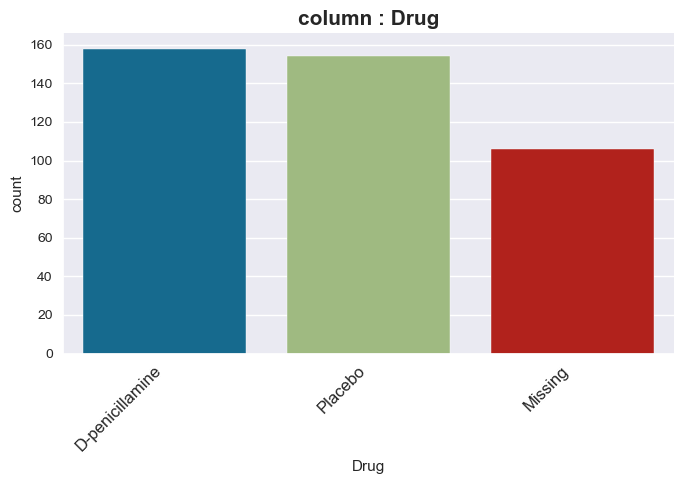

There is 106 NaN (25.36%)
There is 3 unique values
The most common value is D-penicillamine , occurs 158 times (37.8%)
Drug: is neither constant or a quasi-constant feauture and should be kept


In [12]:
explore_cat(df,'Drug');

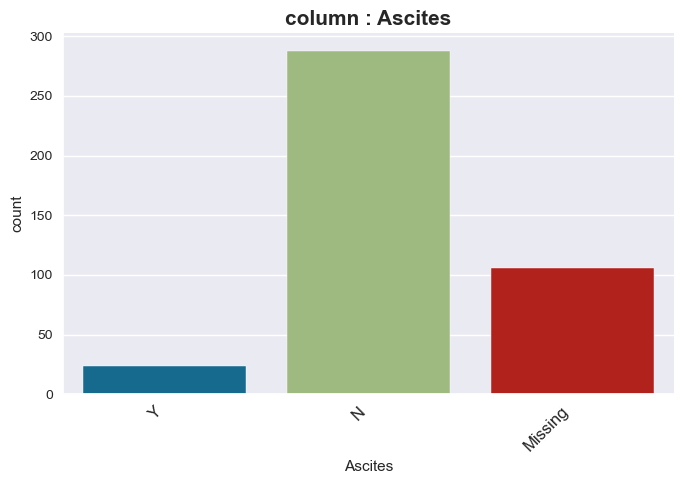

There is 106 NaN (25.36%)
There is 3 unique values
The most common value is N , occurs 288 times (68.9%)
Ascites: is neither constant or a quasi-constant feauture and should be kept


In [13]:
explore_cat(df,'Ascites');

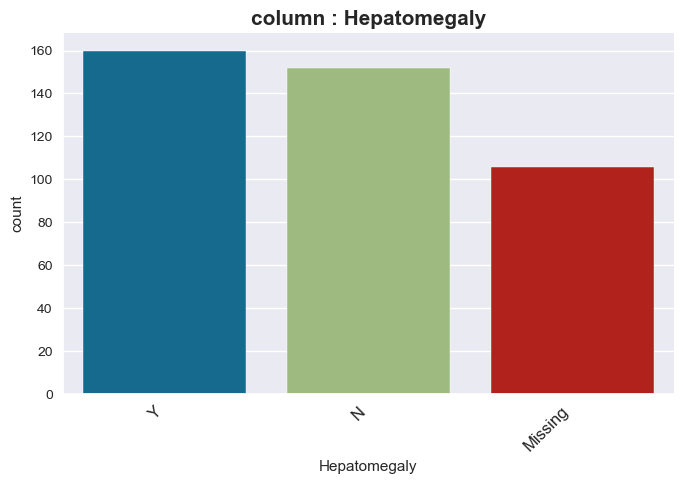

There is 106 NaN (25.36%)
There is 3 unique values
The most common value is Y , occurs 160 times (38.28%)
Hepatomegaly: is neither constant or a quasi-constant feauture and should be kept


In [14]:
explore_cat(df,'Hepatomegaly');

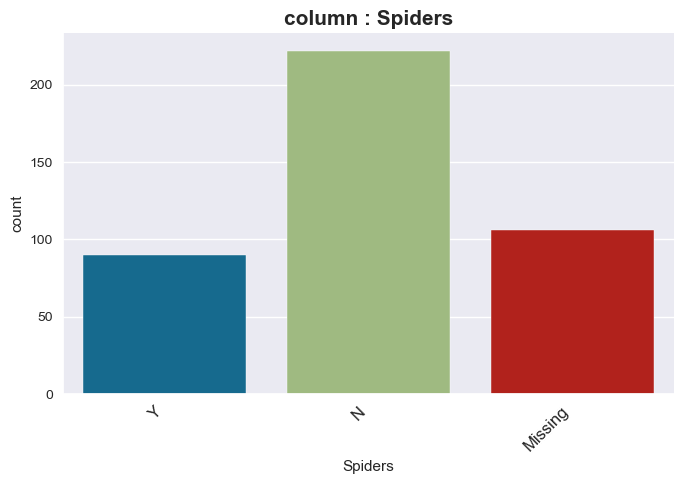

There is 106 NaN (25.36%)
There is 3 unique values
The most common value is N , occurs 222 times (53.11%)
Spiders: is neither constant or a quasi-constant feauture and should be kept


In [15]:
explore_cat(df,'Spiders');

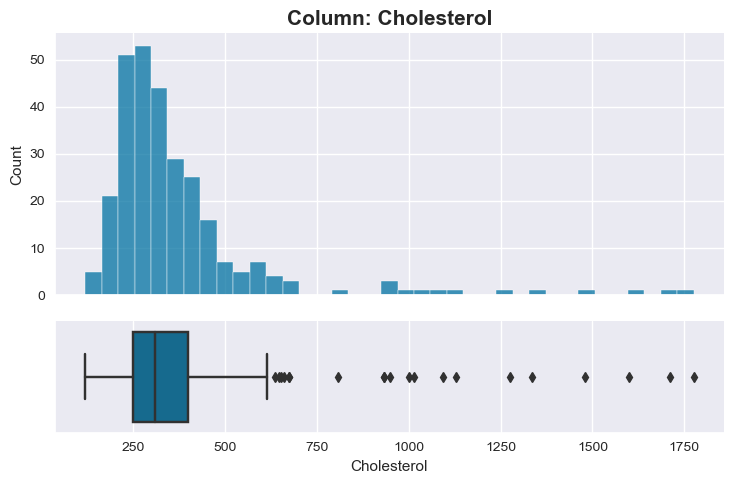

There are 134 NaN (32.06%)
There are 201 unique values
The most common value is nan, occurs 134 times (32.06%)
Cholesterol: is neither constant nor a quasi-constant feature and should be kept


In [16]:
explore_num(df,'Cholesterol');

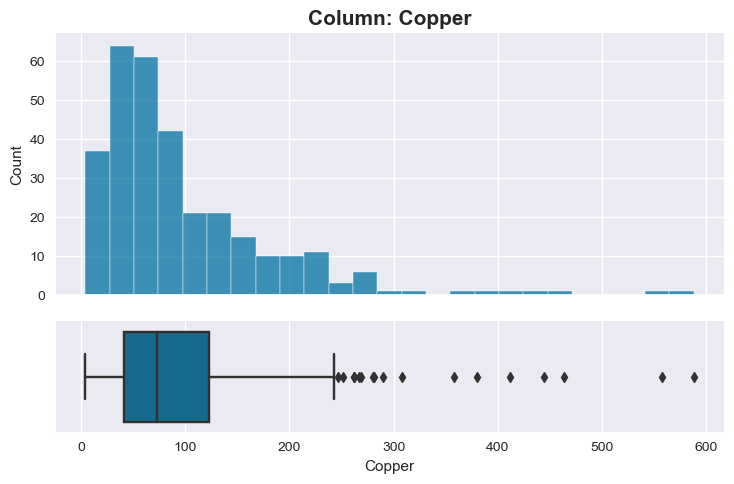

There are 108 NaN (25.84%)
There are 158 unique values
The most common value is nan, occurs 108 times (25.84%)
Copper: is neither constant nor a quasi-constant feature and should be kept


In [17]:
explore_num(df,'Copper');   

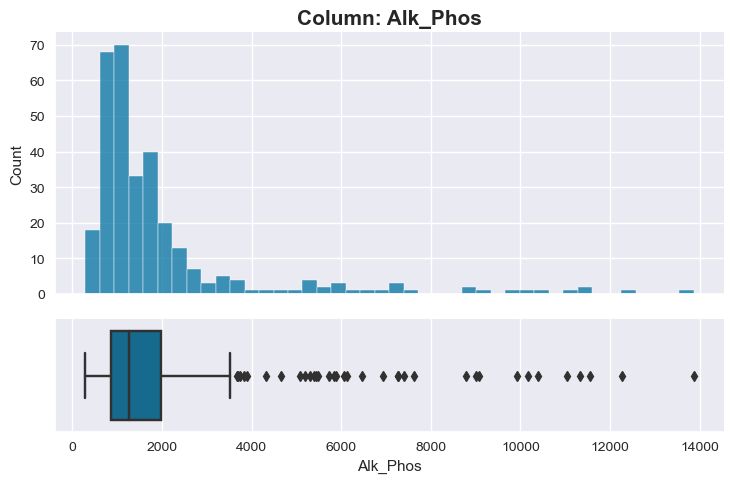

There are 106 NaN (25.36%)
There are 295 unique values
The most common value is nan, occurs 106 times (25.36%)
Alk_Phos: is neither constant nor a quasi-constant feature and should be kept


In [18]:
explore_num(df,'Alk_Phos');    

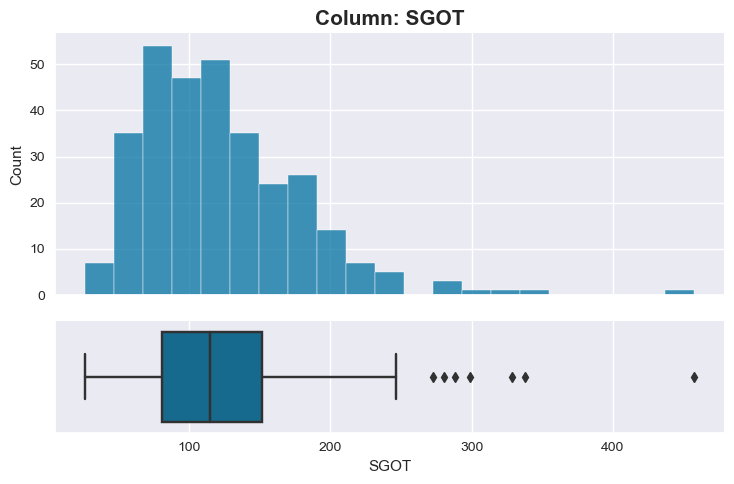

There are 106 NaN (25.36%)
There are 179 unique values
The most common value is nan, occurs 106 times (25.36%)
SGOT: is neither constant nor a quasi-constant feature and should be kept


In [19]:
explore_num(df,'SGOT');  

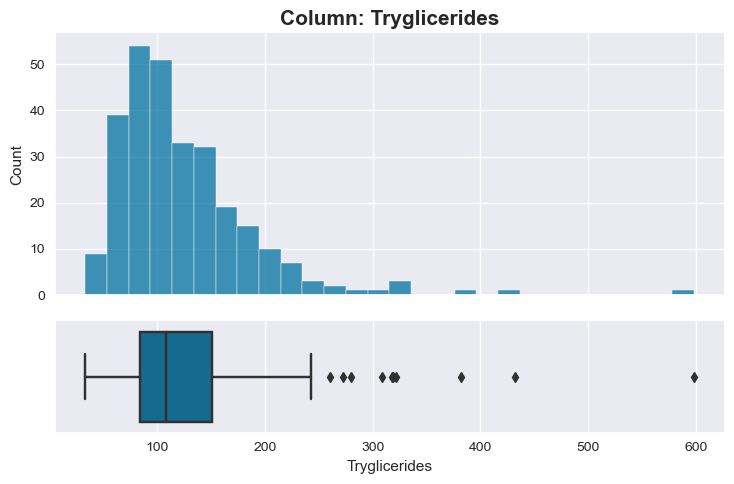

There are 136 NaN (32.54%)
There are 146 unique values
The most common value is nan, occurs 136 times (32.54%)
Tryglicerides: is neither constant nor a quasi-constant feature and should be kept


In [20]:
explore_num(df,'Tryglicerides');  

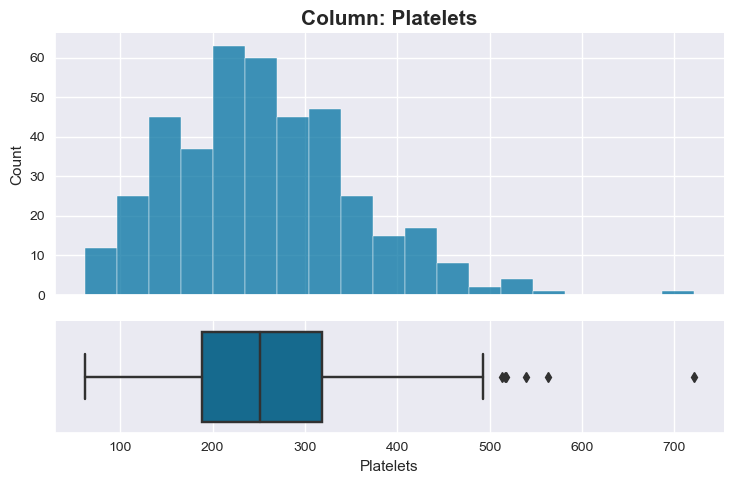

There are 11 NaN (2.63%)
There are 243 unique values
The most common value is nan, occurs 11 times (2.63%)
Platelets: is neither constant nor a quasi-constant feature and should be kept


In [21]:
explore_num(df,'Platelets');

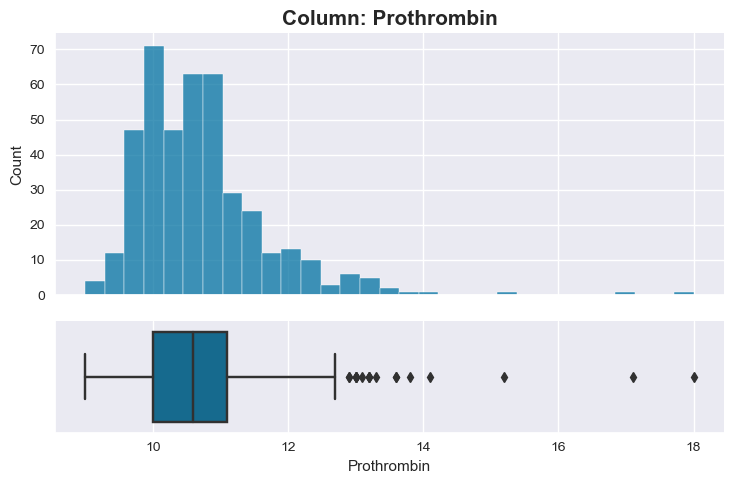

There are 2 NaN (0.48%)
There are 48 unique values
The most common value is 10.6, occurs 39 times (9.33%)
Prothrombin: is neither constant nor a quasi-constant feature and should be kept


In [22]:
explore_num(df,'Prothrombin');

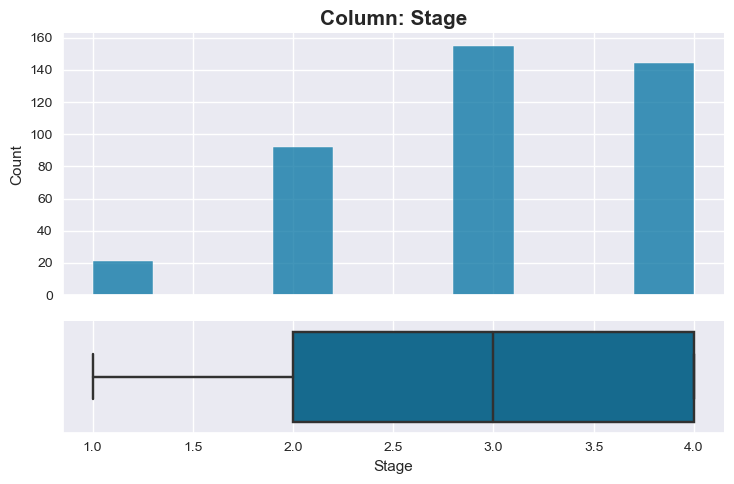

There are 6 NaN (1.44%)
There are 4 unique values
The most common value is 3.0, occurs 155 times (37.08%)
Stage: is neither constant nor a quasi-constant feature and should be kept


In [23]:
explore_num(df,'Stage');

In [24]:
df['Stage'] = df['Stage'].fillna(df['Stage'].mode()[0])

In [25]:
df.isna().sum()

ID                 0
N_Days             0
Status             0
Drug             106
Age                0
Sex                0
Ascites          106
Hepatomegaly     106
Spiders          106
Edema              0
Bilirubin          0
Cholesterol      134
Albumin            0
Copper           108
Alk_Phos         106
SGOT             106
Tryglicerides    136
Platelets         11
Prothrombin        2
Stage              0
dtype: int64

In [26]:
df.describe().round(2)

,ID,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
count,418.00,418.00,418.00,418.00,284.00,418.00,310.00,312.00,312.00,282.00,407.00,416.00,418.00
mean,209.50,1917.78,18533.35,3.22,369.51,3.50,97.65,1982.66,122.56,124.70,257.02,10.73,3.02
std,120.81,1104.67,3815.85,4.41,231.94,0.42,85.61,2140.39,56.70,65.15,98.33,1.02,0.88
min,1.00,41.00,9598.00,0.30,120.00,1.96,4.00,289.00,26.35,33.00,62.00,9.00,1.00
25%,105.25,1092.75,15644.50,0.80,249.50,3.24,41.25,871.50,80.60,84.25,188.50,10.00,2.00
50%,209.50,1730.00,18628.00,1.40,309.50,3.53,73.00,1259.00,114.70,108.00,251.00,10.60,3.00
75%,313.75,2613.50,21272.50,3.40,400.00,3.77,123.00,1980.00,151.90,151.00,318.00,11.10,4.00
max,418.00,4795.00,28650.00,28.00,1775.00,4.64,588.00,13862.40,457.25,598.00,721.00,18.00,4.00


-For the numerical type we can use mean or median. In this case we will go with median to avoid skewing in the presence of outliers.

-For Categorical type we will impute the most frequent class.

We will deal with the msiising values after the split.

In [27]:
df['Sex'] = df['Sex'].replace({'M':0, 'F':1})                                # Male : 0 , Female :1
df['Ascites'] = df['Ascites'].replace({'N':0, 'Y':1})                        # N : 0, Y : 1   
df['Drug'] = df['Drug'].replace({'D-penicillamine':0, 'Placebo':1})          # D-penicillamine : 0, Placebo : 1   
df['Hepatomegaly'] = df['Hepatomegaly'].replace({'N':0, 'Y':1})              # N : 0, Y : 1
df['Spiders'] = df['Spiders'].replace({'N':0, 'Y':1})                        # N : 0, Y : 1
df['Edema'] = df['Edema'].replace({'N':0, 'Y':1, 'S':-1})                    # N : 0, Y : 1, S : -1
df['Status'] = df['Status'].replace({'C':0, 'CL':1, 'D':-1}) 

In [28]:
df['Days_stayed_by_age'] = df.apply(lambda x: x['N_Days'] / x['Age'], axis=1)

In [29]:
X = df.drop(['ID', 'N_Days', 'Stage'], axis=1)
y = df['Stage']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=420)

In [30]:
num_col = X_train.select_dtypes('number').columns
cat_col = X_train.select_dtypes('object').columns

In [31]:
scaler = StandardScaler()
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')
cat_encoder = OneHotEncoder(sparse_output=False , handle_unknown='ignore' )

In [32]:
num_pipe = make_pipeline(num_imputer , scaler)
cat_pipe = make_pipeline(cat_imputer)
num_tuples = ('num',num_pipe,num_col)
cat_tuples = ('cat',cat_pipe,cat_col)

In [33]:
transformer = ColumnTransformer([num_tuples,cat_tuples],verbose_feature_names_out=False)

In [34]:
X_train_tr = transformer.fit_transform(X_train)
X_test_tr = transformer.transform(X_test)

# Model Selection

In [35]:
_ = setup(data=X_train_tr,target=y_train,session_id=420)

,Description,Value
0,Session id,420
1,Target,Stage
2,Target type,Multiclass
3,Target mapping,"1.0: 0, 2.0: 1, 3.0: 2, 4.0: 3"
4,Original data shape,"(313, 19)"
5,Transformed data shape,"(313, 19)"
6,Transformed train set shape,"(219, 19)"
7,Transformed test set shape,"(94, 19)"
8,Numeric features,18
9,Preprocess,True


In [36]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.4974,0.0000,0.4974,0.4999,0.4810,0.2406,0.2484,0.8300
rf,Random Forest Classifier,0.4883,0.6864,0.4883,0.4804,0.4673,0.2201,0.2273,0.1100
lda,Linear Discriminant Analysis,0.4790,0.0000,0.4790,0.4821,0.4606,0.2108,0.2195,0.0120
ridge,Ridge Classifier,0.4747,0.0000,0.4747,0.4546,0.4450,0.1894,0.2000,0.0250
knn,K Neighbors Classifier,0.4740,0.6622,0.4740,0.4768,0.4552,0.2105,0.2152,0.0580
lightgbm,Light Gradient Boosting Machine,0.4699,0.6889,0.4699,0.4577,0.4488,0.1925,0.1977,0.2880
xgboost,Extreme Gradient Boosting,0.4563,0.6800,0.4563,0.4292,0.4335,0.1834,0.1877,0.0770
gbc,Gradient Boosting Classifier,0.4517,0.0000,0.4517,0.4320,0.4273,0.1731,0.1772,0.3300
dt,Decision Tree Classifier,0.4420,0.5918,0.4420,0.4365,0.4264,0.1811,0.1852,0.0170
qda,Quadratic Discriminant Analysis,0.4284,0.0000,0.4284,0.4347,0.4095,0.1477,0.1556,0.0140


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=420, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

# Modeling

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

In [38]:
lr = LogisticRegression()
rfc = RandomForestClassifier()
lr.fit(X_train_tr,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [39]:
rfc.fit(X_train_tr,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=None,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [40]:
train_preds_lr = lr.predict(X_train_tr)
test_preds_lr = lr.predict(X_test_tr)
train_preds_rfc = rfc.predict(X_train_tr)
test_preds_rfc = rfc.predict(X_test_tr)

              precision    recall  f1-score   support

         1.0       0.50      0.14      0.22        14
         2.0       0.52      0.36      0.42        70
         3.0       0.52      0.69      0.59       123
         4.0       0.67      0.61      0.64       106

    accuracy                           0.57       313
   macro avg       0.55      0.45      0.47       313
weighted avg       0.57      0.57      0.55       313



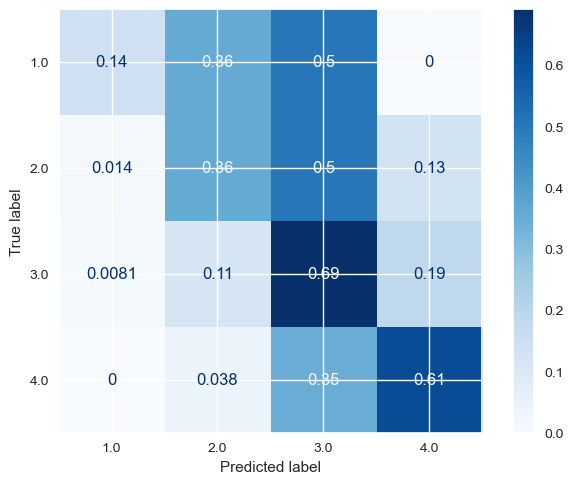

In [41]:
ConfusionMatrixDisplay.from_estimator(lr, X_train_tr, y_train, cmap = 'Blues',normalize='true');
print(classification_report(y_train, train_preds_lr));

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         7
         2.0       0.19      0.14      0.16        22
         3.0       0.41      0.55      0.47        38
         4.0       0.66      0.61      0.63        38

    accuracy                           0.45       105
   macro avg       0.31      0.32      0.31       105
weighted avg       0.43      0.45      0.43       105



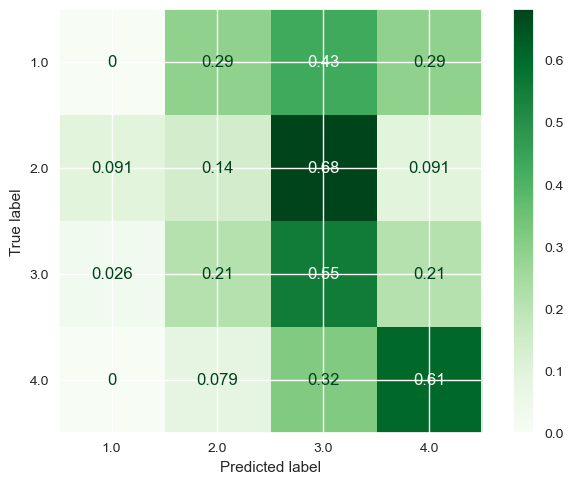

In [42]:
ConfusionMatrixDisplay.from_estimator(lr, X_test_tr, y_test, cmap = 'Greens',normalize='true');
print(classification_report(y_test, test_preds_lr));

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        14
         2.0       1.00      1.00      1.00        70
         3.0       1.00      1.00      1.00       123
         4.0       1.00      1.00      1.00       106

    accuracy                           1.00       313
   macro avg       1.00      1.00      1.00       313
weighted avg       1.00      1.00      1.00       313



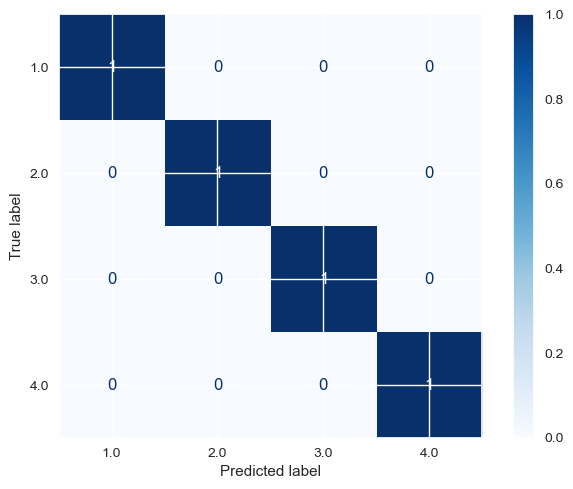

In [43]:
ConfusionMatrixDisplay.from_estimator(rfc, X_train_tr, y_train, cmap = 'Blues',normalize='true');
print(classification_report(y_train, train_preds_rfc));

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         7
         2.0       0.40      0.18      0.25        22
         3.0       0.47      0.71      0.56        38
         4.0       0.59      0.58      0.59        38

    accuracy                           0.50       105
   macro avg       0.37      0.37      0.35       105
weighted avg       0.47      0.50      0.47       105



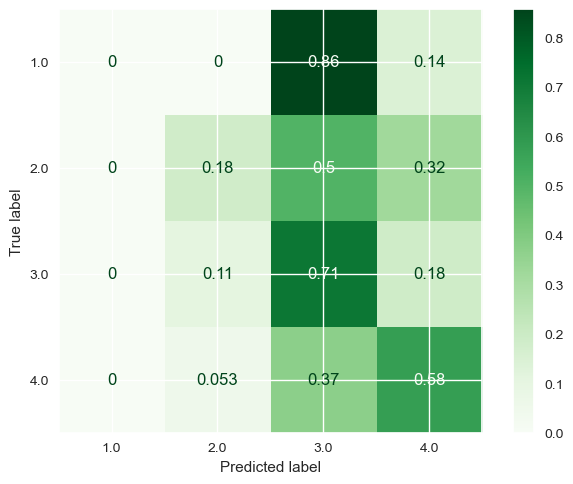

In [44]:
ConfusionMatrixDisplay.from_estimator(rfc, X_test_tr, y_test, cmap = 'Greens',normalize='true');
print(classification_report(y_test, test_preds_rfc));

In [45]:
lr_params = {'penalty':['l1','l2','elasticnet',None],
            'C':[0.01,0.1,1,10,100],
            'solver':['newton-cg','sag','saga','lbfgs']}
rfc_params = {'bootstrap':[True,False],
             'criterion':['gini', 'entropy', 'log_loss'],
             'max_depth':[3,5,8,11]}

In [46]:
lr_grid = GridSearchCV(lr,lr_params)
lr_grid.fit(X_train_tr,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             n_jobs=None,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2', 'elasticnet', None],
                         'solver': ['newton-cg', 'sag', 'saga', 'lbfgs']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [47]:
rfc_grid = GridSearchCV(rfc,rfc_params)
rfc_grid.fit(X_train_tr,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='sqrt',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              monotonic_cst=None,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             n_jobs=None,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [3, 5, 8, 11]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [48]:
best_lr = lr_grid.best_estimator_
best_rfc = rfc_grid.best_estimator_
preds_best_lr = best_lr.predict(X_test_tr)
preds_best_rfc = best_rfc.predict(X_test_tr)

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         7
         2.0       0.00      0.00      0.00        22
         3.0       0.42      0.71      0.53        38
         4.0       0.61      0.66      0.63        38

    accuracy                           0.50       105
   macro avg       0.26      0.34      0.29       105
weighted avg       0.37      0.50      0.42       105



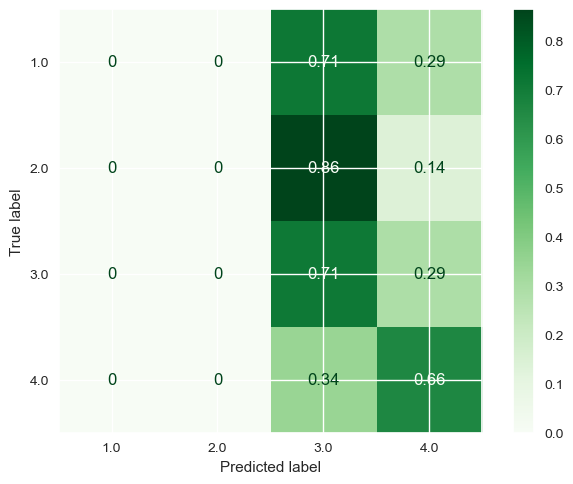

In [49]:
ConfusionMatrixDisplay.from_estimator(best_lr, X_test_tr, y_test, cmap = 'Greens',normalize='true');
print(classification_report(y_test, preds_best_lr));

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         7
         2.0       1.00      0.05      0.09        22
         3.0       0.44      0.89      0.59        38
         4.0       0.70      0.50      0.58        38

    accuracy                           0.51       105
   macro avg       0.54      0.36      0.32       105
weighted avg       0.62      0.51      0.44       105



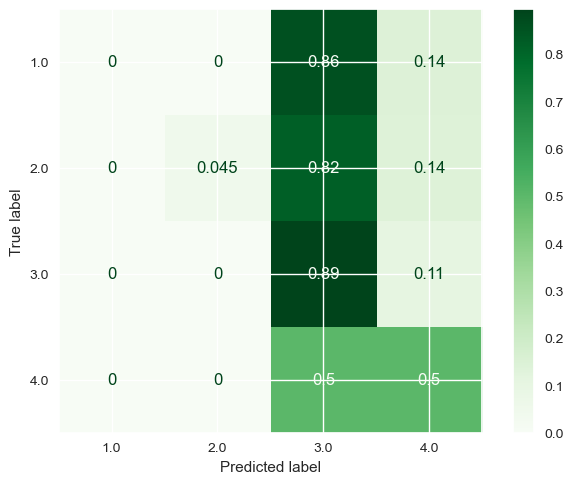

In [50]:
ConfusionMatrixDisplay.from_estimator(best_rfc, X_test_tr, y_test, cmap = 'Greens',normalize='true');
print(classification_report(y_test, preds_best_rfc));

# PCA

In [51]:
from sklearn.decomposition import PCA
pca = PCA(n_components=.95)
scaler2 = StandardScaler()
pca_pipe = make_pipeline(scaler2,pca)

In [52]:
X_train_pca = pca_pipe.fit_transform(X_train_tr)
X_test_pca = pca_pipe.transform(X_test_tr)

In [53]:
lr2 = LogisticRegression()
rfc2 = RandomForestClassifier()

In [54]:
lr2.fit(X_train_pca,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [55]:
rfc2.fit(X_train_pca,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=None,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [56]:
lr2_preds = lr2.predict(X_test_pca)
rfc2_preds = rfc2.predict(X_test_pca)

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         7
         2.0       0.19      0.14      0.16        22
         3.0       0.42      0.58      0.48        38
         4.0       0.71      0.63      0.67        38

    accuracy                           0.47       105
   macro avg       0.33      0.34      0.33       105
weighted avg       0.44      0.47      0.45       105



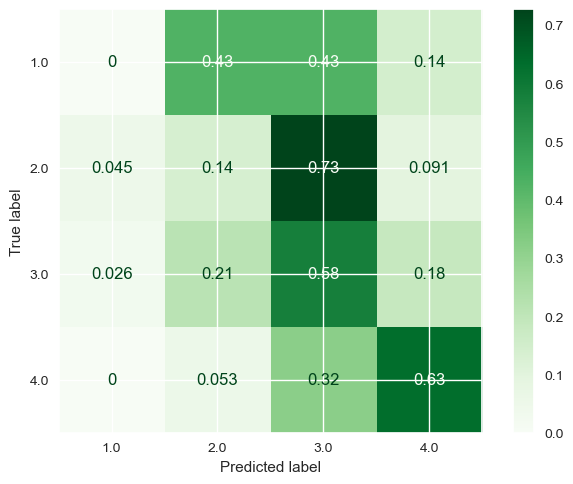

In [58]:
ConfusionMatrixDisplay.from_estimator(lr2, X_test_pca, y_test, cmap = 'Greens',normalize='true');
print(classification_report(y_test, lr2_preds));

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         7
         2.0       0.26      0.23      0.24        22
         3.0       0.41      0.45      0.43        38
         4.0       0.58      0.68      0.63        38

    accuracy                           0.46       105
   macro avg       0.31      0.34      0.33       105
weighted avg       0.41      0.46      0.43       105



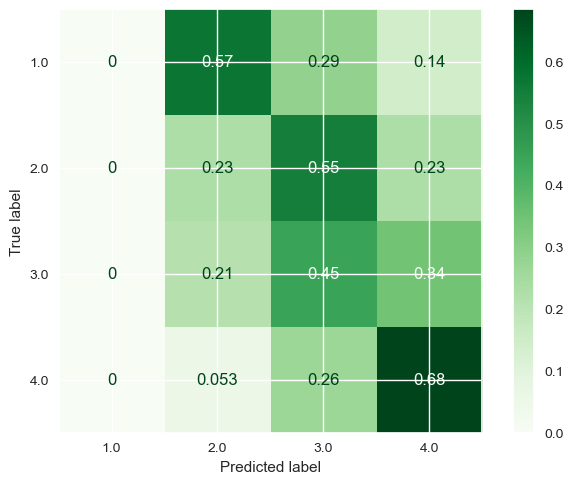

In [59]:
ConfusionMatrixDisplay.from_estimator(rfc2, X_test_pca, y_test, cmap = 'Greens',normalize='true');
print(classification_report(y_test, rfc2_preds));

In [60]:
lr2_grid = GridSearchCV(lr2,lr_params)
lr2_grid.fit(X_train_pca,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             n_jobs=None,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2', 'elasticnet', None],
                         'solver': ['newton-cg', 'sag', 'saga', 'lbfgs']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [63]:
rfc2_grid = GridSearchCV(rfc2,rfc_params)
rfc2_grid.fit(X_train_pca,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='sqrt',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              monotonic_cst=None,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             n_jobs=None,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [3, 5, 8, 11]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [65]:
best_lr2 = lr2_grid.best_estimator_
best_rfc2 = rfc2_grid.best_estimator_
preds_best_lr2 = best_lr2.predict(X_test_pca)
preds_best_rfc2 = best_rfc2.predict(X_test_pca)

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         7
         2.0       0.00      0.00      0.00        22
         3.0       0.46      0.84      0.59        38
         4.0       0.71      0.66      0.68        38

    accuracy                           0.54       105
   macro avg       0.29      0.38      0.32       105
weighted avg       0.42      0.54      0.46       105



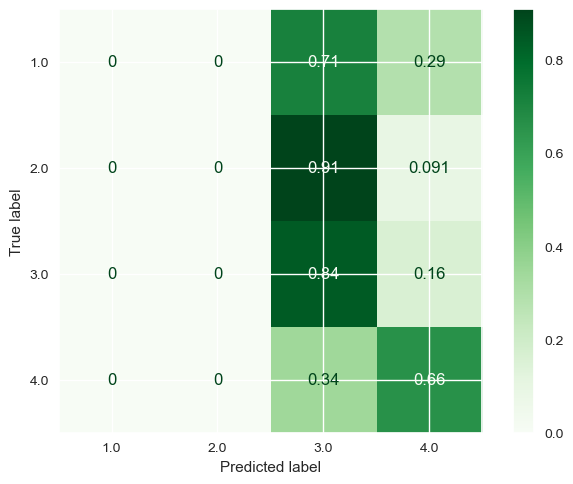

In [66]:
ConfusionMatrixDisplay.from_estimator(best_lr2, X_test_pca, y_test, cmap = 'Greens',normalize='true');
print(classification_report(y_test, preds_best_lr2));

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         7
         2.0       0.67      0.09      0.16        22
         3.0       0.44      0.68      0.54        38
         4.0       0.63      0.71      0.67        38

    accuracy                           0.52       105
   macro avg       0.43      0.37      0.34       105
weighted avg       0.53      0.52      0.47       105



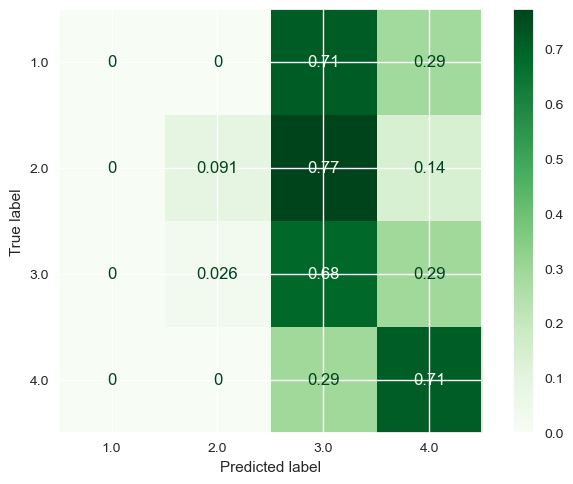

In [67]:
ConfusionMatrixDisplay.from_estimator(best_rfc2, X_test_pca, y_test, cmap = 'Greens',normalize='true');
print(classification_report(y_test, preds_best_rfc2));